Step 1

In [1]:
import pandas as pd

In [2]:
# Load dataset
col_name = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises?", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape",
    "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]

data = pd.read_csv("agaricus-lepiota.data", delim_whitespace=False, header=None)

data.columns = col_name

# Check for missing values
missing_values = data.isnull().sum()

print("Missing values:")
print(missing_values)


Missing values:
class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises?                    0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


C:\Users\annazoi\AppData\Local\Temp\ipykernel_11088\373982602.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv("agaricus-lepiota.data", delim_whitespace=False, header=None)


Step 2 - Encoding to numerical values

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
label_encoder = LabelEncoder()

for col in data.columns:
    data[col] = label_encoder.fit_transform(data[col])

data.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


Step 3

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# data.describe()

Feature correlations with target variable

class                       1.000000
gill-size                   0.540024
population                  0.298686
habitat                     0.217179
cap-surface                 0.178446
spore-print-color           0.171961
veil-color                  0.145142
gill-attachment             0.129200
cap-shape                   0.052951
cap-color                  -0.031384
odor                       -0.093552
stalk-shape                -0.102019
stalk-color-below-ring     -0.146730
stalk-color-above-ring     -0.154003
ring-number                -0.214366
stalk-surface-below-ring   -0.298801
stalk-surface-above-ring   -0.334593
gill-spacing               -0.348387
stalk-root                 -0.379361
ring-type                  -0.411771
bruises?                   -0.501530
gill-color                 -0.530566
veil-type                        NaN
Name: class, dtype: float64


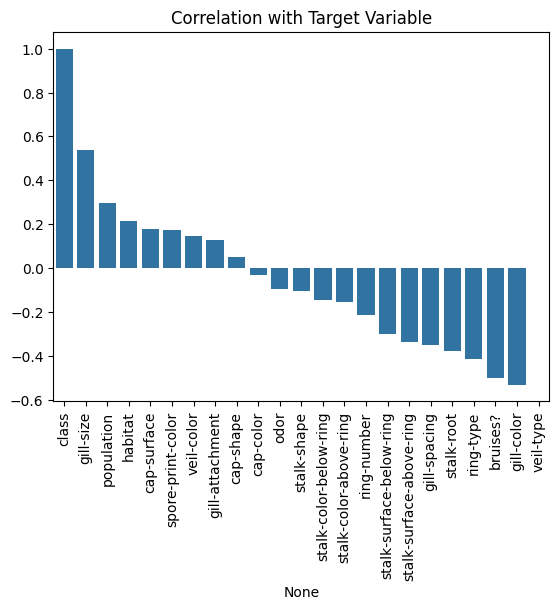

In [7]:
# We want correlation with target variable (class), so:
# data.corr()["class"]
values=data.corr()["class"].sort_values(ascending=False)
print(values)

# Plot the correlation
sns.barplot(x=values.index, y=values.values)
plt.xticks(rotation=90)
plt.title("Correlation with Target Variable")
plt.show()

selected_features_correlation = values[values.abs() > 0.1].index.tolist()
selected_features_correlation.remove("class")  

Step 4

In [8]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [9]:
X = data.drop("class", axis=1)
y = data["class"]

# Build Random Forest model
rf = RandomForestClassifier()

# Build step forward feature selection
sfs = SFS(rf, k_features=10, forward=True, floating=False, scoring='accuracy', cv=5, n_jobs=-1)
sfs = sfs.fit(X, y)

# Selected features
selected_features_sfs = list(sfs.k_feature_names_)
print(" Selected Features by SFS:", selected_features_sfs)

 Selected Features by SFS: ['cap-surface', 'odor', 'gill-attachment', 'gill-size', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color']


Step 5

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Dataset 1
X_corr = data[selected_features_correlation]

# Dataset 2
X_sfs = data[selected_features_sfs]

# Split the dataset
X_corr_train, X_corr_test, y_train, y_test = train_test_split(X_corr, y, test_size=0.3, random_state=42)
X_sfs_train, X_sfs_test, _, _ = train_test_split(X_sfs, y, test_size=0.3, random_state=42)


Step 6

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [13]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}

results = {}

# Train and evaluate on both datasets
for name, clf in classifiers.items():
    clf.fit(X_corr_train, y_train)
    y_pred_corr = clf.predict(X_corr_test)
    auc_corr = roc_auc_score(y_test, y_pred_corr)
    
    clf.fit(X_sfs_train, y_train)
    y_pred_sfs = clf.predict(X_sfs_test)
    auc_sfs = roc_auc_score(y_test, y_pred_sfs)
    
    results[name] = {"Correlation AUC": auc_corr, "SFS AUC": auc_sfs}

print("Model Results:")
print(results)

Model Results:
{'Logistic Regression': {'Correlation AUC': np.float64(0.9501032995917191), 'SFS AUC': np.float64(0.9156388913026932)}, 'Decision Tree': {'Correlation AUC': np.float64(1.0), 'SFS AUC': np.float64(0.9902624894157493)}, 'Random Forest': {'Correlation AUC': np.float64(1.0), 'SFS AUC': np.float64(0.9902624894157493)}, 'KNN': {'Correlation AUC': np.float64(1.0), 'SFS AUC': np.float64(0.9894157493649449)}}


Step 7

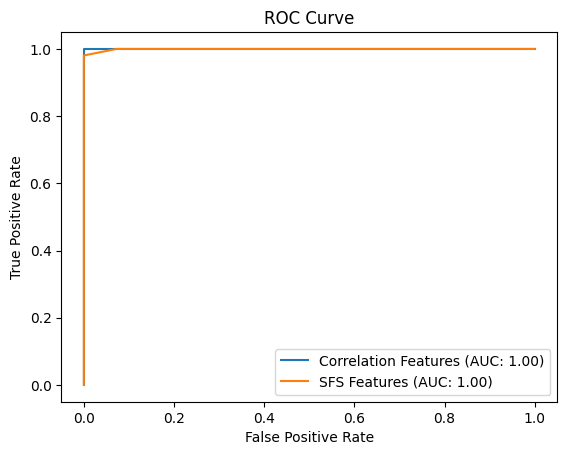

In [ ]:
# Plot ROC curve
rf.fit(X_corr_train, y_train)
# Predict probabilities
y_pred_prob_corr = rf.predict_proba(X_corr_test)[:, 1]
fpr_corr, tpr_corr, _ = roc_curve(y_test, y_pred_prob_corr)

rf.fit(X_sfs_train, y_train)
y_pred_prob_sfs = rf.predict_proba(X_sfs_test)[:, 1]
fpr_sfs, tpr_sfs, _ = roc_curve(y_test, y_pred_prob_sfs)

plt.plot(fpr_corr, tpr_corr, label="Correlation Features (AUC: {:.2f})".format(roc_auc_score(y_test, y_pred_prob_corr)))
plt.plot(fpr_sfs, tpr_sfs, label="SFS Features (AUC: {:.2f})".format(roc_auc_score(y_test, y_pred_prob_sfs)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()